In [1]:
import collections, itertools, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cPickle as pkl
import matplotlib
from representations.sequentialembedding import SequentialEmbedding
from ggplot import *
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline
matplotlib.rcParams["figure.figsize"] = "11.5, 6"

/Users/sob/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/sob/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/sob/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
class aligned_embeddings:
    def __init__(self, embeddings_folder):        
        self.fiction_embeddings = SequentialEmbedding.load(embeddings_folder, range(1900, 2000, 10))
        self.freq_dict = self.load_counts("embeddings/counts", range(1900, 2000, 10))
        self.counts = self.load_pos("embeddings/pos_new", range(1900, 2000, 10))
        self.parts_of_speech = ['PRON', 'NUM', 'NOUN', 'VERB', 'PRT', 'ADJ', 'ADP', 'DET', 'ADV']
    
    """ PLOTTING TSNE """
    
    def get_neighbors(self, num_words = 2):
        neighbour_set = set([])
        for year in self.years:
            closest = self.fiction_embeddings.embeds[year].closest(self.main_word, n=num_words+1)
            for _, neighbour in closest:
                neighbour_set.add(neighbour)
        return list(neighbour_set)

    def get_word_data(self):
        neighbors = self.get_neighbors()
        emb_sub = {}
        for year in self.years:
            df = pd.DataFrame()
            for neighbor in neighbors:
                df = df.append(pd.DataFrame(self.fiction_embeddings.embeds[year][neighbor]).transpose(), ignore_index=True)
            neighbors_altered = [word + "(" + str(year) + ")" if word == self.main_word else word for word in neighbors]
            df['word'] = pd.Series(neighbors_altered, index=df.index)
            emb_sub[year] = df
        return emb_sub

    def train_tsne(self):
        emb_sub = self.get_word_data()
        num_years = len(self.years)
        tsne_df = {}
        edited_main_word = self.main_word + '\(1'
        for i in range(num_years, 0, -1):
            y = list(emb_sub.keys())[i-1]
            tsne = TSNE(n_components = 2, perplexity = 5)
            X_tsne = tsne.fit_transform(emb_sub[y].iloc[:,0:300])
            scaler = MinMaxScaler(copy = True, feature_range = (-1, 1))
            X_tsne_scaled = pd.DataFrame(scaler.fit_transform(X_tsne))
            X_tsne_scaled.columns = ["x",  "y"]
            X_tsne_scaled["word"] = emb_sub[y]["word"].values
            if i == num_years:
                tsne_df[y] = X_tsne_scaled
            else:
                tsne_df[y] = X_tsne_scaled[X_tsne_scaled.word.str.contains(edited_main_word)]
        tsne_df = pd.concat(tsne_df)
        tsne_df = tsne_df.reset_index(drop = True)
        tsne_df["color"] = ["red" if x.find(self.main_word) >= 0 else "blue" for x in tsne_df["word"]]
        return tsne_df

    def plot_tsne(self): 
        tsne_viz = self.train_tsne()
        matplotlib.style.use('ggplot')
        fig = ggplot(aes(x= "x", y= "y", label = "word", colour = "color"), tsne_viz) +\
         geom_text() + geom_point()
        fig.show()
        
    """ PLOTTING RELATIVE FREQUENCY """
    
    def load_counts(self, freq_folder, years = range(1900, 2000, 10)):
        freq_files = ["/" + str(y) + "-counts.pkl" for y in years]
        freq_dict = {}
        for f in freq_files:
            freq_dict[int(f[1:5])] = pkl.load(open(freq_folder + f, "rb"))
        return freq_dict    
    
    def get_relative_freq(self):
        word_freq = {}
        for year in self.years:
            if self.main_word in self.freq_dict[year]:
                word_freq[year] = self.freq_dict[year][self.main_word]/sum(self.freq_dict[year].values())
            else:
                word_freq[year] = 0
        tmp = pd.DataFrame(list(word_freq.items()))
        tmp.columns = ["year", "freq"]
        return tmp
    
    def plot_relative_freq(self):
        tmp = self.get_relative_freq()
        matplotlib.style.use('ggplot')
        fig2 = ggplot(aes(x = "year", y = "freq"), tmp) +\
         geom_line()
        fig2.show()
        return fig2
        
    """ PLOTTING PARTS OF SPEECH """
    
    def load_pos(self, pos_folder, years = range(1900, 2000, 10)):
        counts = collections.OrderedDict()
        for year in years:
            counts[year] = pkl.load(open(pos_folder + "/" + str(year) + '-pos_counts.pkl', "rb"))
        return counts

    def get_pos_x_time(self):
        different_pos = [self.counts[year][self.main_word] for year in self.years]
        all_pos_x_time = list(set(itertools.chain.from_iterable([pos.keys() for pos in different_pos]))) # get all PoS across years
        return all_pos_x_time, different_pos
    
    def get_pos_df(self):
        pos_names, different_pos = self.get_pos_x_time()
        groups = collections.defaultdict(list)
        for name in pos_names: 
            for entry in different_pos:
                groups[name].append(entry[name])
        
        df = pd.DataFrame(groups, index=self.years)
        df_percentage = df.divide(df.sum(axis=1), axis=0) # We need to transform the data from raw data to percentage (fraction)
        stacked = [df_percentage[pos] for pos in df.keys() if pos in self.parts_of_speech]   
        return stacked, df.keys()
    
    def plot_pos(self):    
        stacked_areas, keys = self.get_pos_df()
        matplotlib.style.use('ggplot')
        plt.stackplot(self.years, stacked_areas, labels=[key for key in keys])
        plt.legend(loc='best')
        plt.margins(0,0)
        plt.title("%s Part of Speech Over Time " % "'"+ self.main_word.title() + "'")
        plt.xlabel('Year')
        plt.ylabel('Percentage of Total Usage')
        plt.show()
        return plt
    
    """ GET COSINE SIMILARITY CONVERGENCE """
    
    def plot_cosine_sim_convergence(self):
        vec = [algn.fiction_embeddings.embeds[self.years[year]].represent(self.main_word).dot(algn.fiction_embeddings.embeds[self.years[year+1]].represent(self.main_word)) for year, _ in enumerate(self.years[:-1])]
        matplotlib.style.use('ggplot')
        plt.plot(self.years[:-1], vec)
        plt.title("%s Diachronic Cosine Similarity Convergence" % "'"+ self.main_word.title() + "'")
        plt.xlabel('Year')
        plt.ylabel('Cosine Similarity')
        plt.show()
        return plt
        
    """ PLOT IT ALL AT ONCE """

    def plot(self, main_word, years):
        self.years = years
        self.main_word = main_word
        
        self.fig1, self.tsne_viz = self.plot_tsne()
        self.fig2 = self.plot_relative_freq()
        self.fig3 = self.plot_pos()
        self.fig4 = self.plot_cosine_sim_convergence()

        # this needs to be fixed.
        self.fig1.show()
        self.fig2.show()
        self.fig3.show()
        self.fig4.show()

In [4]:
import time
start = time.time()
algn = aligned_embeddings("embeddings/aligned")
end = time.time()
print end - start

50.0886170864


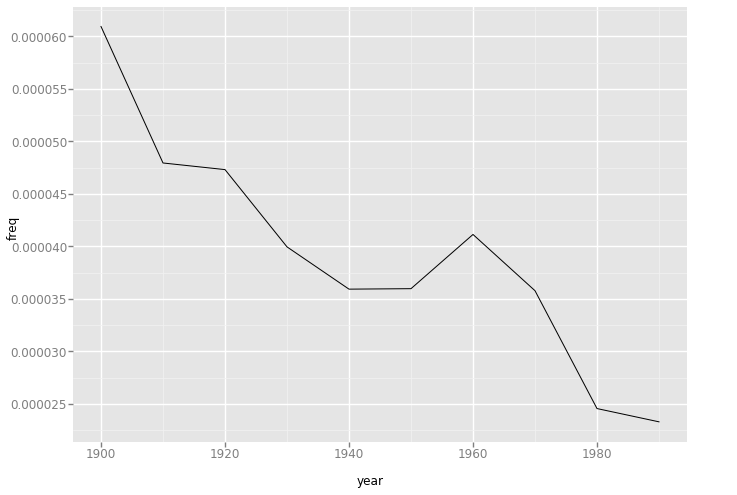

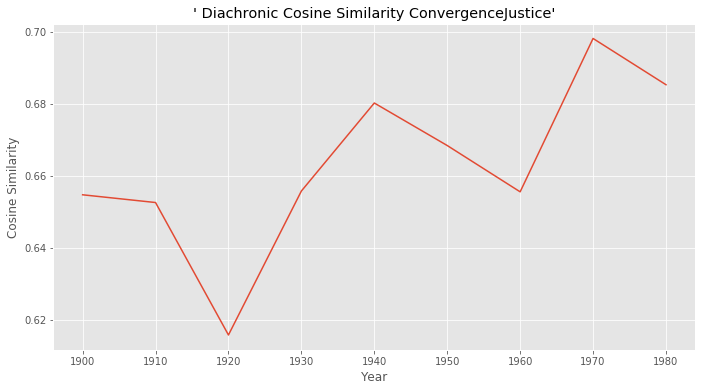

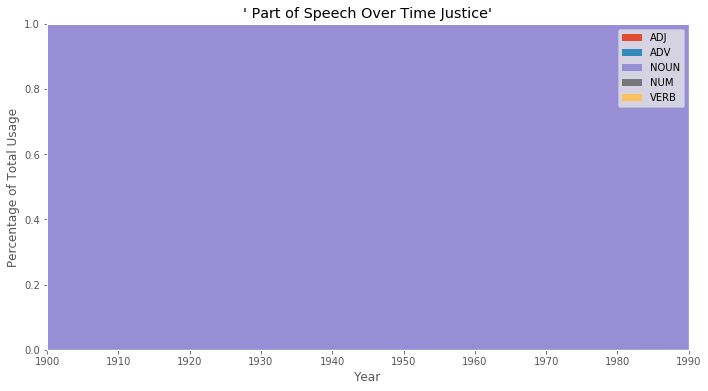

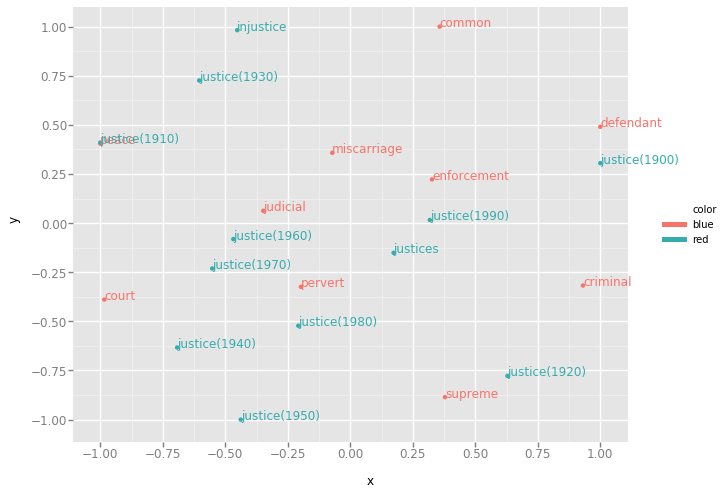

In [7]:
matplotlib.rcParams["figure.figsize"] = "11.5, 6"
algn.main_word = 'justice'
algn.years = range(1900, 2000, 10)

algn.plot_relative_freq()
algn.plot_cosine_sim_convergence()
algn.plot_pos()
algn.plot_tsne()